# House prices: Kaggle training competition

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt

# For nicer plots
#import scienceplots
#plt.style.use(['science', 'notebook'])

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

### Useful routines

In [2]:
# Plotting routines
# Create subplots

def scatter_against_one(y_var, x_vars, df, n_cols=4, fsize=(15,8)):
    # Number of rows and columns in the grid
    n_rows = -(-len(x_vars) // n_cols)  # Calculate number of rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fsize)
    
    # Flatten the axes array to easily index it
    axes = axes.flatten()
    
    # Loop through columns and plot scatter for each
    for i, col in enumerate(x_vars):
        sns.scatterplot(data=df, x=col, y=y_var, ax=axes[i])
        #axes[i].set_title(f'Price vs {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(y_var)
    
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

## EDA

In [2]:
hp_train = pd.read_csv('./data/train.csv')
hp_test = pd.read_csv('./data/test.csv')

In [3]:
print(hp_train.head(3))
print("Training data shape: ", hp_train.shape)
print("Test data shape: ", hp_test.shape)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]
Training data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [26]:
print(hp_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
print(hp_train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
hp_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

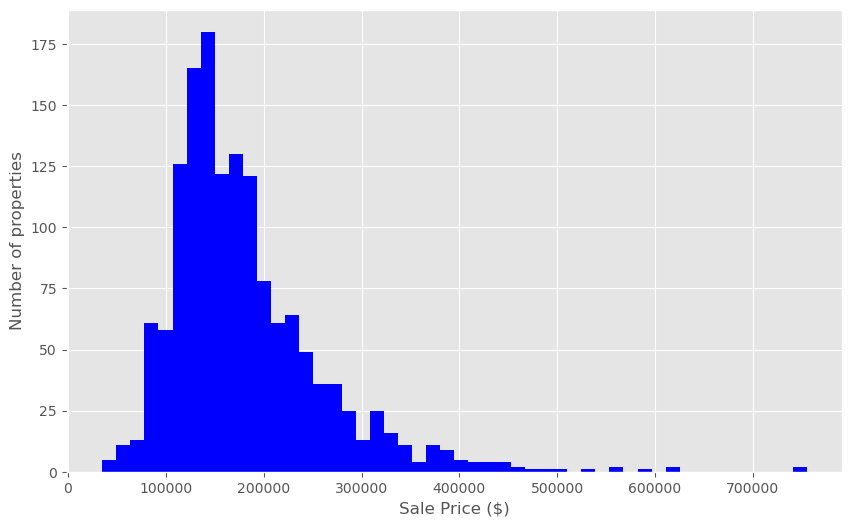

In [6]:
fig, ax = plt.subplots()
ax.hist(hp_train['SalePrice'], bins=50, color='blue')
ax.set_xlabel('Sale Price ($)')
ax.set_ylabel('Number of properties')
plt.show()

In [7]:
# Check skewness
print("Skew on the target variable is: ", hp_train['SalePrice'].skew())

Skew on the target variable is:  1.8828757597682129


The skew is above 1, which suggests a high degree of skewness.
We can change this somewhat by taking a logarithm of the target variable

Skew on transformed target variable is:  0.12133506220520406


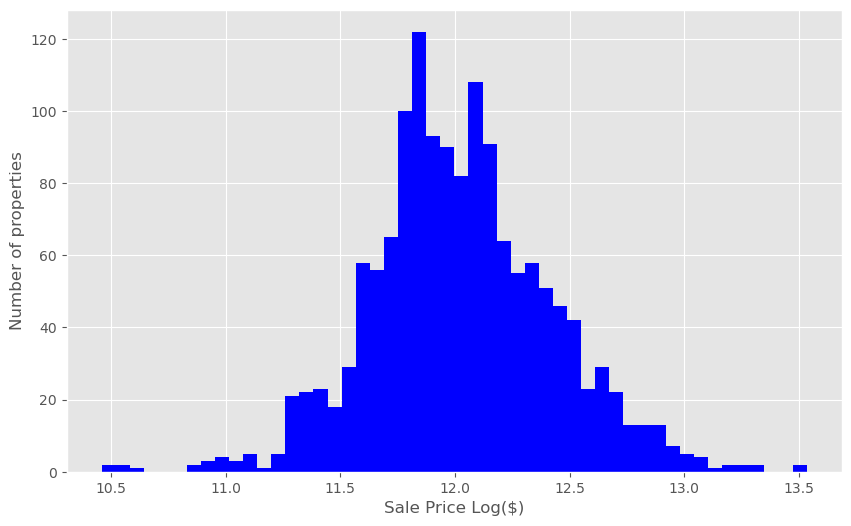

In [8]:
target = np.log(hp_train['SalePrice'])
print("Skew on transformed target variable is: ", target.skew())
fig, ax = plt.subplots()
ax.hist(target, bins=50, color='blue')
ax.set_xlabel('Sale Price Log($)')
ax.set_ylabel('Number of properties')
plt.show()

In [9]:
# Get unique datatypes
list(set(hp_train.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]


Lets investigate the numeric part of the dataset for now

In [10]:
hp_train_num = hp_train.select_dtypes([np.number])
hp_train_num.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

Start by looking for correlations - which numerical feature does sales price seem to be strongly correlated with?

In [11]:

correlations = hp_train_num.corr()

print("Correlations on original data set")
print("Most positively correlated")
print(correlations['SalePrice'].sort_values(ascending=False).head())
print()
print("Most negatively correlated")
print(correlations['SalePrice'].sort_values(ascending=False).tail())

Correlations on original data set
Most positively correlated
SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

Most negatively correlated
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [12]:
overallQual_pivot = hp_train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=[np.median, np.mean])
overallQual_pivot

/tmp/ipykernel_10210/2289302423.py:1: FutureWarning: The provided callable <function median at 0x70707575c540> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  overallQual_pivot = hp_train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=[np.median, np.mean])
/tmp/ipykernel_10210/2289302423.py:1: FutureWarning: The provided callable <function mean at 0x70707611ede0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  overallQual_pivot = hp_train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=[np.median, np.mean])


,median,mean
,SalePrice,SalePrice
OverallQual,,
1,50150.0,50150.000000
2,60000.0,51770.333333
3,86250.0,87473.750000
4,108000.0,108420.655172
5,133000.0,133523.347607
6,160000.0,161603.034759
7,200141.0,207716.423197
8,269750.0,274735.535714


In [25]:
overallQual_pivot['median']['SalePrice']

OverallQual
1      50150.0
2      60000.0
3      86250.0
4     108000.0
5     133000.0
6     160000.0
7     200141.0
8     269750.0
9     345000.0
10    432390.0
Name: SalePrice, dtype: float64

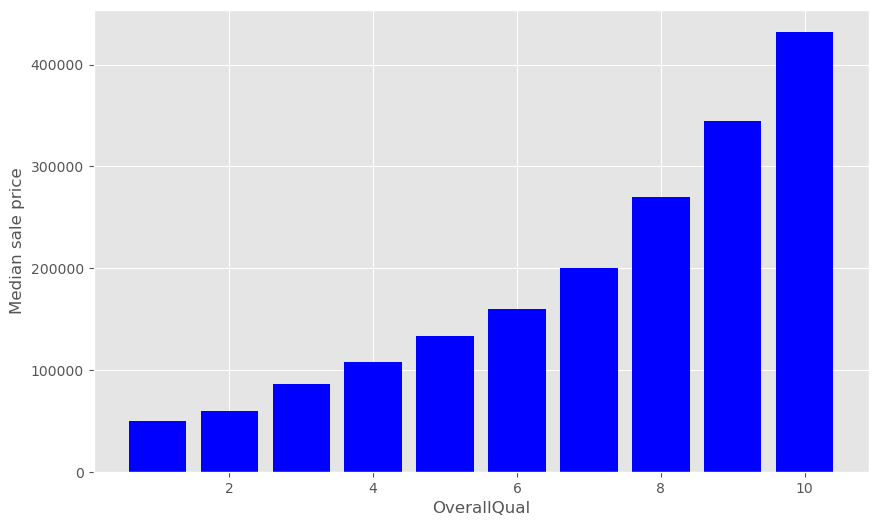

In [26]:
plt.bar(x=overallQual_pivot.index.values , height=overallQual_pivot['median']['SalePrice'], color='blue')
plt.xlabel('OverallQual')
plt.ylabel('Median sale price')
plt.xticks(rotation=0)
plt.show()

#### Ground living area & garage area

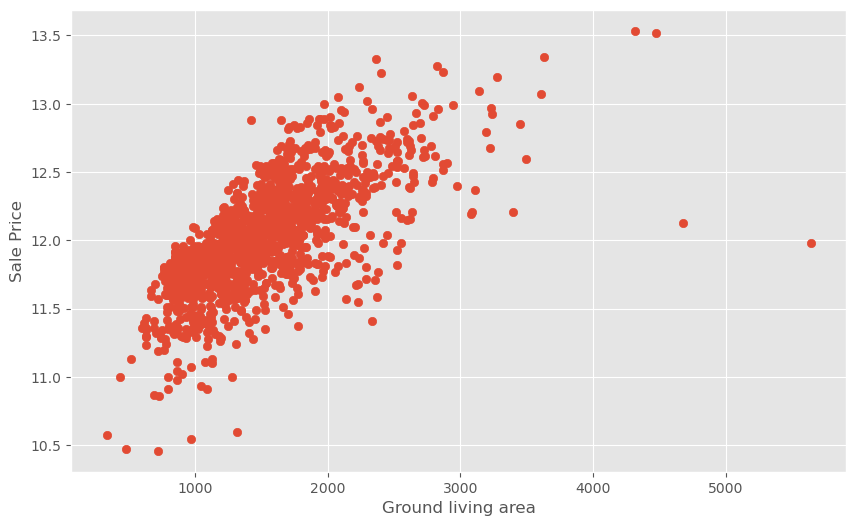

In [27]:
plt.scatter(x=hp_train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Ground living area')
plt.show()

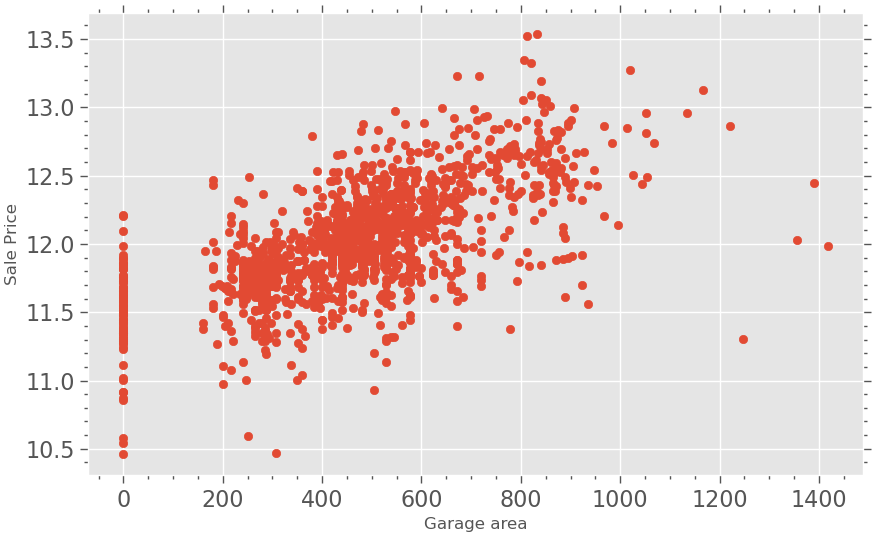

In [63]:
plt.scatter(x=hp_train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage area')
plt.show()

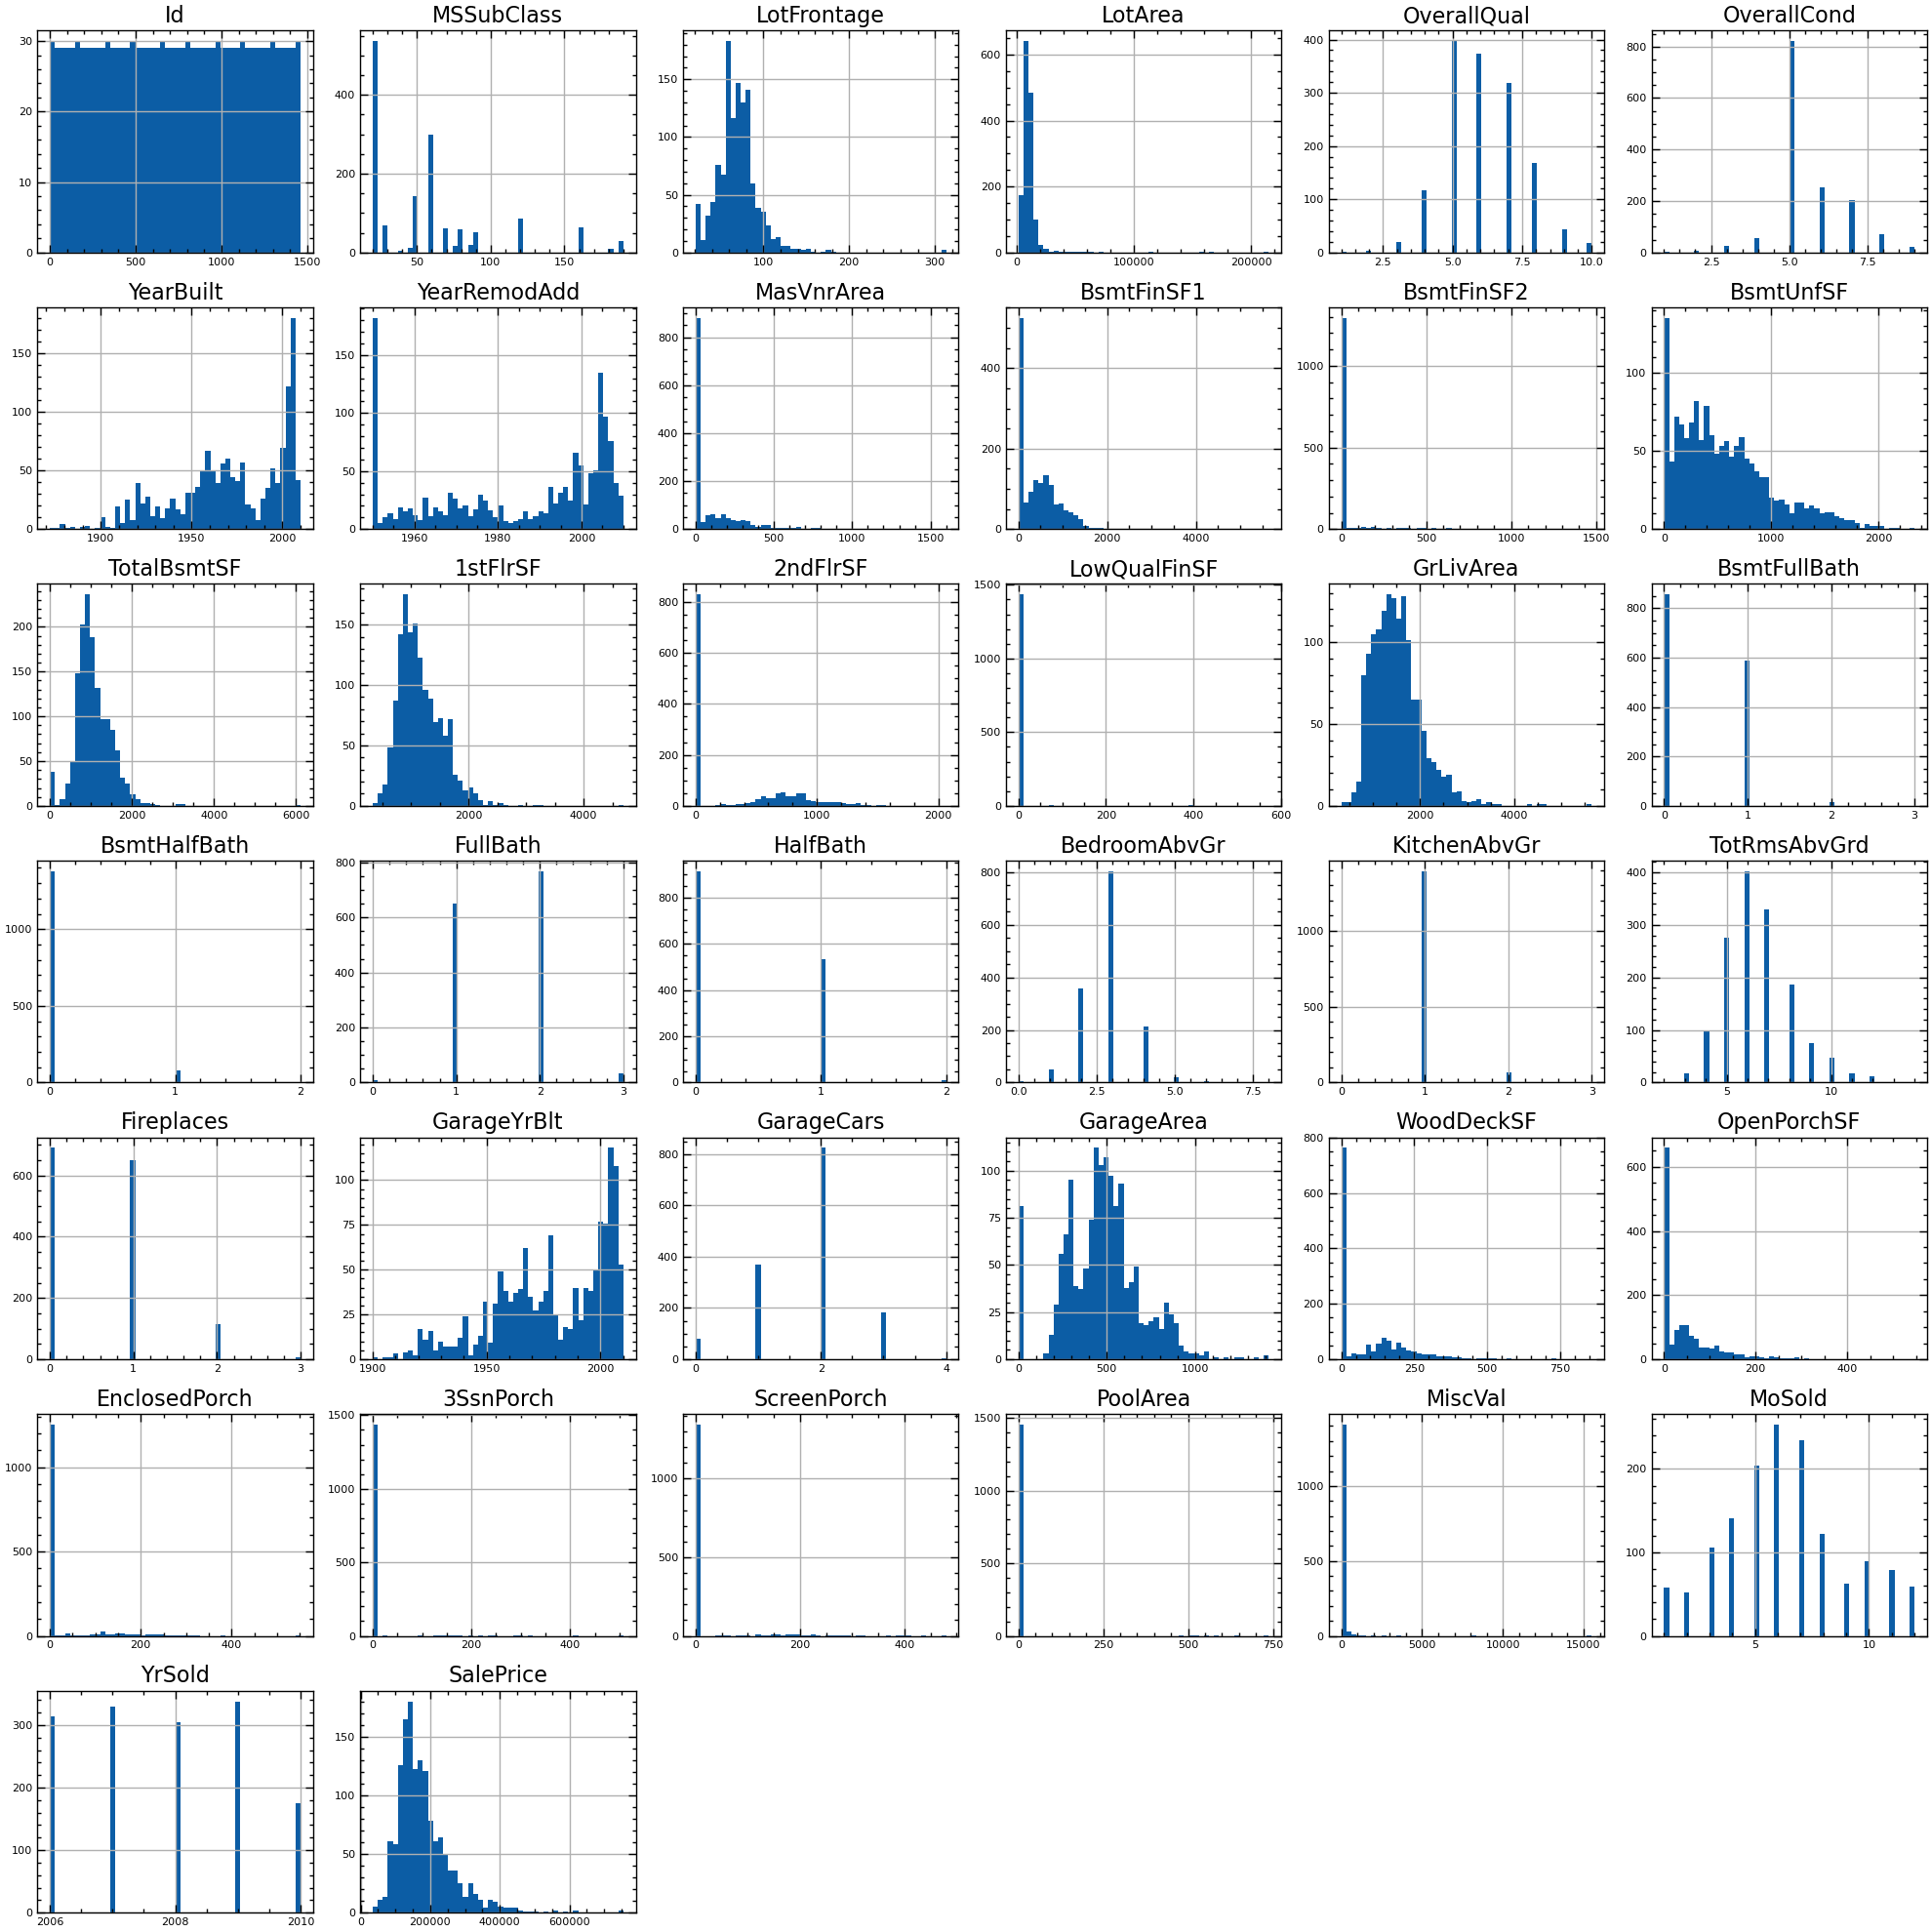

In [122]:
hp_train_num.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [61]:
hp_train['BedroomAbvGr'].value_counts()
hp_train['FullBath'].value_counts()
hp_train['KitchenAbvGr'].value_counts()

KitchenAbvGr
1    1392
2      65
3       2
0       1
Name: count, dtype: int64

### Any obvious correlations
We will check for correlations between house price and some characteristics of the house 

We some columns it's not useful to check against, such as most categorical columns (not all for now, e.g. quality is graded in a way that makes sense 0 -> 10 from bad to good)

In [62]:
ignored_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

cols1 = hp_train.columns.drop(['Id'] + ignored_cols + ['SalePrice'])#['LotArea', 'OverallQual', 'OverallCond', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']
print(cols1)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


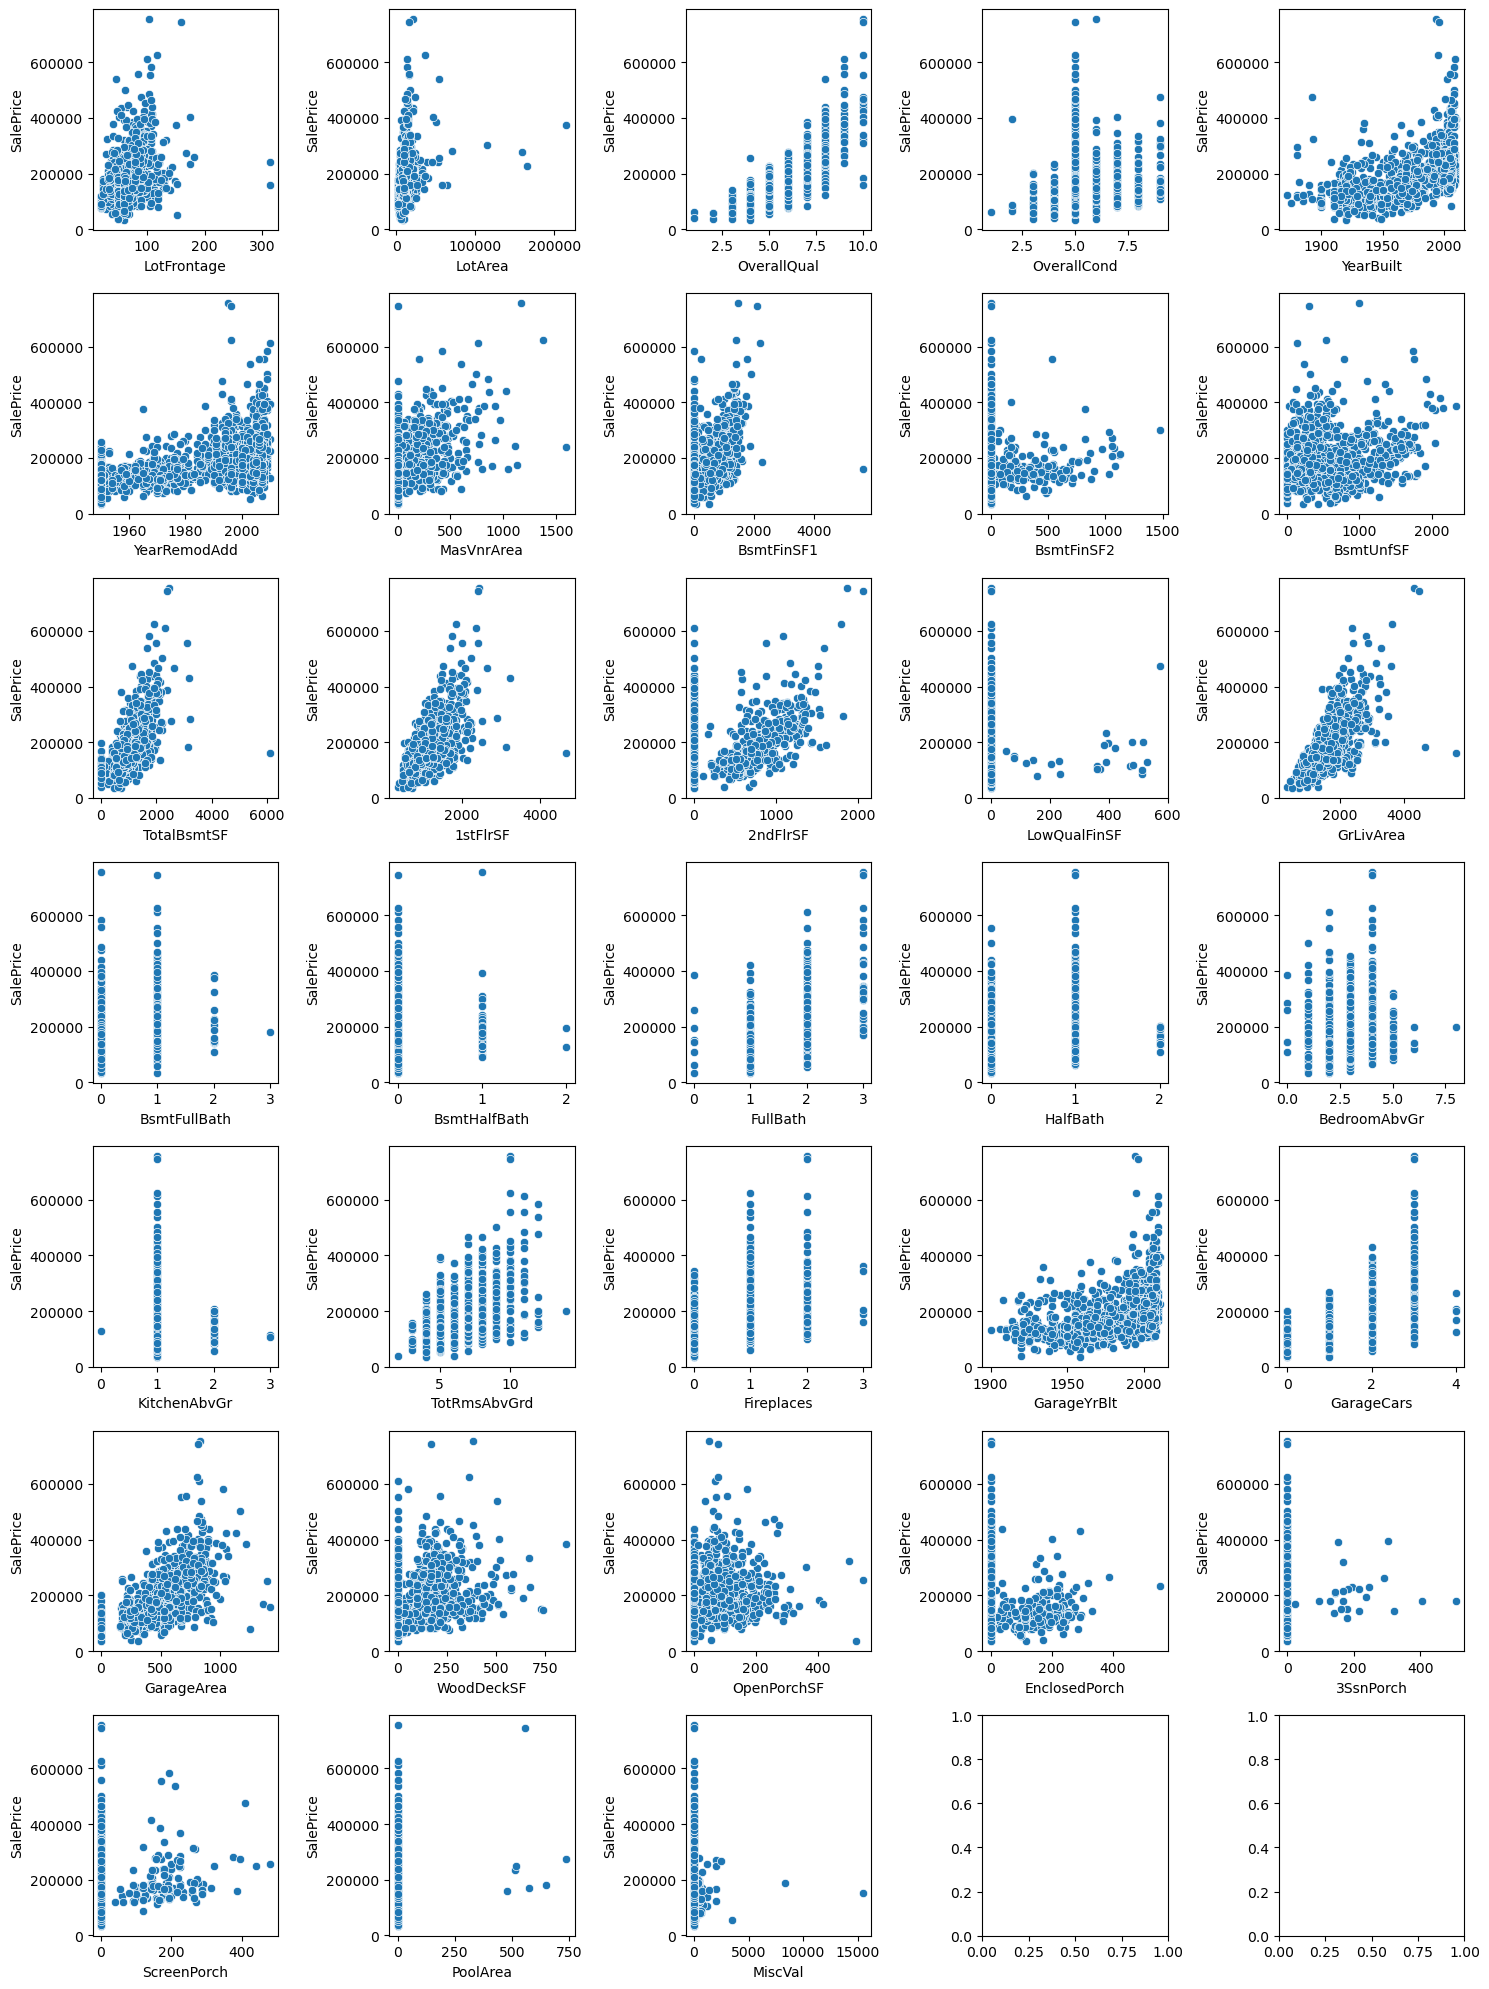

In [64]:
# Put SalePrice on the y-axis to see if there are any obvious correlations
scatter_against_one('SalePrice', cols1, hp_train, n_cols=5, fsize=(15,20))

In [66]:
hp_train['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [68]:
hp_train['Utilities'].value_counts()

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

In [69]:
hp_train['LotConfig'].value_counts()

LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64

In [70]:
hp_train['Exterior1st'].value_counts()

Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64

In [75]:
print(hp_train['BsmtQual'].value_counts(dropna=False))
print(hp_train['BsmtCond'].value_counts(dropna=False))
print(hp_train['BsmtExposure'].value_counts(dropna=False))

BsmtQual
TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: count, dtype: int64
BsmtCond
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: count, dtype: int64
BsmtExposure
No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: count, dtype: int64


17401.149999999998


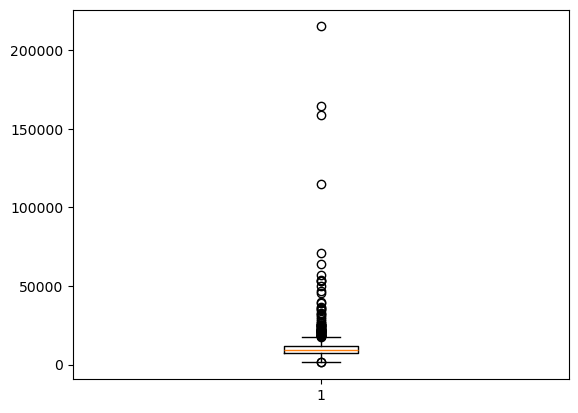

In [26]:
plt.boxplot(hp_train['LotArea'])
print(hp_train['LotArea'].quantile(0.95))
plt.show()

## Baseline modelling

In [53]:
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(hp_train[['OverallQual', 'GrLivArea']], target, test_size=0.3, random_state=42)
model.fit(X_train, y_train)
y_pred = pd.Series(np.exp(model.predict(X_test)), index=X_test.index)

r2_score = model.score(X_test, y_test)
rmse = root_mean_squared_error(np.exp(y_test), y_pred)

In [54]:
print(r2_score)
print(rmse)

0.7720058928997654
37154.525696464276


In [57]:
np.exp(y_train).describe()

count      1022.000000
mean     181312.692759
std       77617.461005
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      215000.000000
max      745000.000000
Name: SalePrice, dtype: float64